<a href="https://colab.research.google.com/github/davidwhogg/rvSensitivity/blob/master/toy_rv_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy experiments in RV sensitivity

Just checking the basics.

In [0]:
import numpy as np
import pylab as plt
#matplotlib inline

In [0]:
def make_observing_program(N, T, periodic=False):
  """
  really dumb observing plans
  """
  if periodic:
    dT = T / N
    return np.arange(0.5 * dT, T, dT)
  return np.sort(T * np.random.uniform(size=N))

In [0]:
Ny = 5 # 5-year survey
N = 150 * Ny
T = 365.25 * Ny
ts = make_observing_program(N, T)
ts.shape

(750,)

In [0]:
# mildly heteroskedastic data around 30 cm/s
sigma = 30.
sigmas = sigma - 0.1 * sigma + 0.2 * sigma * np.random.uniform(size=N) # cm/s
ivars = 1. / sigmas ** 2

In [0]:
# logarithmic period grid
Pmin = 2. ** 4 # days
Pmax = 2. ** 14 # days
Ps = np.exp(np.arange(np.log(Pmin), np.log(Pmax)+0.001, 0.125))
Ps.shape

(56,)

In [0]:
def design_matrix(P, phase, ts):
  """
  This is supposed to do the Kepler problem but it doesn't!
  """
  return np.vstack((np.cos(2. * np.pi * ts / P + phase), np.ones_like(ts))).T

def precisions(Ps, ts, ivars):
  # coarse grid for phase integral
  Nphase = 16
  dph = 2. * np.pi / Nphase
  phases = np.arange(0.5 * dph, 2. * np.pi, dph)
  infos = np.zeros_like(Ps)
  for ii, P in enumerate(Ps):
    for phi in phases:
      A = design_matrix(P, phi, ts)
      infos[ii] += (1. / np.linalg.inv(A.T * ivars @ A)[0, 0]) / Nphase # doing an integral
  return infos

In [0]:
infos_P = precisions(Ps, ts, ivars)
uncertainties_P = 1. / np.sqrt(infos_P)

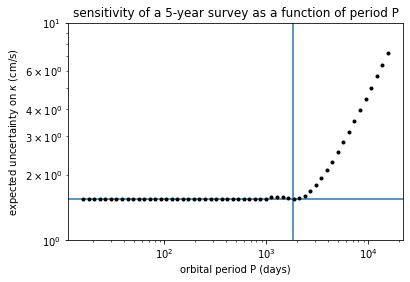

In [0]:
plt.axvline(T)
plt.axhline(sigma / np.sqrt(N / 2))
plt.plot(Ps, uncertainties_P, "k.")
plt.loglog()
plt.ylim(1., 10.)
plt.ylabel(r"expected uncertainty on $\kappa$ (cm/s)")
plt.xlabel("orbital period P (days)")
plt.title("sensitivity of a {:d}-year survey as a function of period P".format(Ny));

In [0]:
fiducialP = 300.0 # days
Nmin = (fiducialP / T) ** 2 * N
Ns = np.ceil(np.exp(np.linspace(np.log(Nmin), np.log(N), 32))).astype(int)
Nsubsurvey = len(Ns)
Ts = np.zeros(Nsubsurvey) # survey elapsed durations
infos_T = np.zeros(Nsubsurvey) # RV precisions
for subsurvey in range(Nsubsurvey):
  tsthis = ts[:Ns[subsurvey]]
  ivarsthis = ivars[:Ns[subsurvey]]
  Ts[subsurvey] = np.max(tsthis) - np.min(tsthis) # dumb
  infos_T[subsurvey] = precisions([fiducialP, ], tsthis, ivarsthis)
uncertainties_T = 1. / np.sqrt(infos_T)

[]

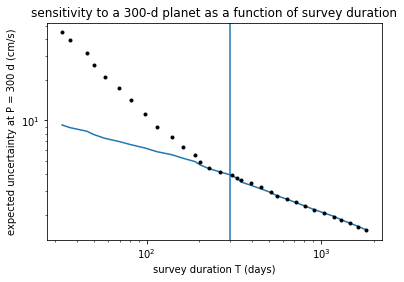

In [0]:
plt.axvline(fiducialP)
plt.plot(Ts, sigma / np.sqrt((Ns / 2)))
plt.plot(Ts, uncertainties_T, "k.")
plt.ylabel("expected uncertainty at P = 300 d (cm/s)")
plt.xlabel("survey duration T (days)")
plt.title("sensitivity to a {:3.0f}-d planet as a function of survey duration".format(fiducialP))
plt.loglog();

In [0]:
def random_orbit(P, kappa, ts):
  """
  Randomize over phase (& eccentricity eventually) to sample a Keplerian at ts.
  Returns noiseless RV timeseries for a randomized orbit.
  """
  phase = np.random.uniform() * 2. * np.pi
  A = design_matrix(P, phase, ts)
  return np.dot(A, [kappa, 0.])

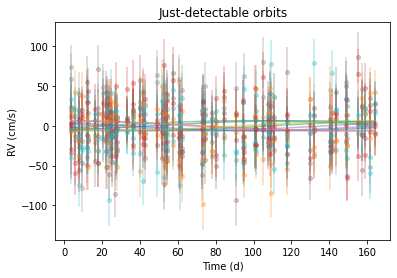

In [0]:
subsurvey = 10
tsthis = ts[:Ns[subsurvey]]
ivarsthis = ivars[:Ns[subsurvey]]
sigs = 1./np.sqrt(ivarsthis) # rv uncertainties
kappa_limit = uncertainties_T[subsurvey]

for i in range(4):
  ys = random_orbit(fiducialP, kappa_limit, tsthis)
  plt.plot(tsthis, ys, alpha=0.5)
  plt.errorbar(tsthis, ys + np.random.normal(np.zeros_like(tsthis), sigs), 
              yerr=sigs, alpha=0.3, fmt='o', ms=4)
plt.xlabel('Time (d)')
plt.ylabel('RV (cm/s)')
#plt.ylim([-sigma,sigma])
plt.title('Just-detectable orbits');

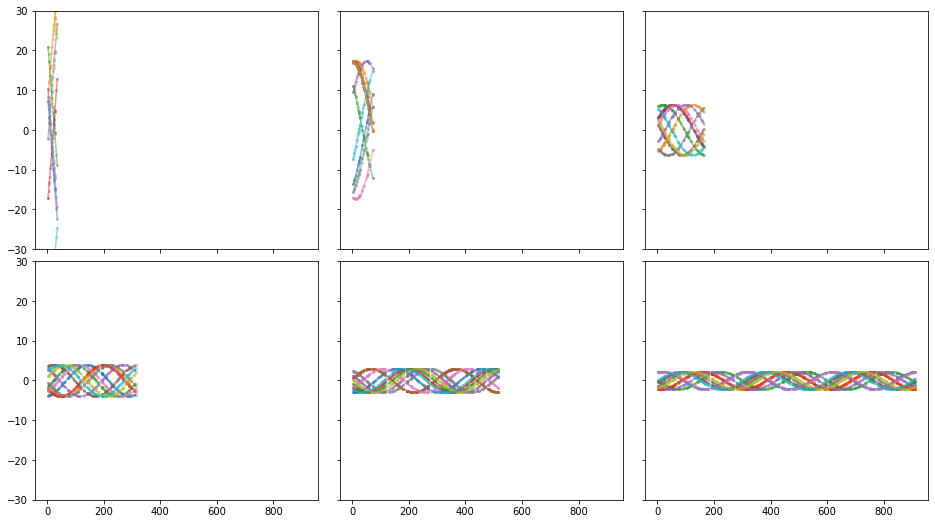

In [0]:
fig, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(16,9), 
                         gridspec_kw={'wspace':0.08, 'hspace':0.05})
for i,ax in enumerate(np.ravel(axes)):
  subsurvey = i * int(Nsubsurvey/len(np.ravel(axes)))
  tsthis = ts[:Ns[subsurvey]] # yoinked
  kappa_limit = uncertainties_T[subsurvey] # smallest detectable planet
  for j in range(8):
    ys = random_orbit(fiducialP, kappa_limit, tsthis)
    ax.plot(tsthis, ys, alpha=0.5)
    ax.scatter(tsthis, ys, alpha=0.3, s=4) # i'm not including noise here
ax.set_ylim([-sigma,sigma]);

**Discussion point:** is it fair to say that we have obtained the required precision on RV amplitude when the survey duration is too short to establish that 300 days is the orbital period? In an actual blind survey this would not count as a detection because after marginalizing over all possible orbital periods, the measured $\kappa$ is way too uncertain.

[]

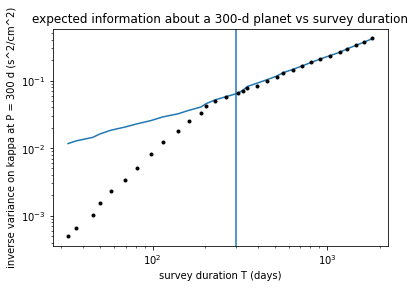

In [0]:
plt.axvline(fiducialP)
plt.plot(Ts, Ns / (2. * sigma ** 2) )
plt.plot(Ts, infos_T, "k.")
plt.ylabel("inverse variance on kappa at P = 300 d (s^2/cm^2)")
plt.xlabel("survey duration T (days)")
plt.title("expected information about a {:3.0f}-d planet vs survey duration".format(fiducialP))
plt.loglog();